In [28]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import shap

In [29]:
pd.options.display.max_columns = None 
pd.options.display.max_rows = None 

In [30]:
def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function

    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum

    # return a float
    return ft_wmape_forecast

In [31]:
def prepare_data(df):
    x1, x2, x3, x4, x5, x6, target = df['1_week_ago'], df['2_week_ago'], df['3_week_ago'], df['4_week_ago'], df['weeks_since_release'], df['avg_claim_last_month'], df['this_week']
    x1, x2, x3, x4, x5, x6, target = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6), np.array(target)
    x1, x2, x3, x4, x5, x6, target = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1), target.reshape(-1, 1)
    features = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
    
    return features, target

In [32]:
iphone12_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone12_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone13_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone13_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone14_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone14_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/time_series_ML_features_final.csv', parse_dates=['weeks_monday','month_year'])
iphone12 = iphone_df[(iphone_df['phone_model'] == 'apple iphone 12')]
iphone13 = iphone_df[(iphone_df['phone_model'] == 'apple iphone 13')]
iphone14 = iphone_df[(iphone_df['phone_model'] == 'apple iphone 14')]

In [33]:
iphone12_df.drop(['month_year', 'holiday'], axis=1, inplace=True)

In [34]:
new_iphone12 = iphone12_df.copy()

days_since_iphone13_release = iphone12_df['days_since_release_date'] - 114
new_iphone12['days_since_release_date'] = days_since_iphone13_release
new_iphone12['weeks_since_release'] = days_since_iphone13_release // 7 
new_iphone12['weeks_monday'] = iphone12_df['weeks_monday'] - pd.Timedelta(days=113)
new_iphone12['month'] = new_iphone12['weeks_monday'].dt.month
new_iphone12['year'] = new_iphone12['weeks_monday'].dt.year
new_iphone12

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,204,2021-05-16,5,2021,252,283.75,215.60,274.0,292.0,224.0,219.0,29
1,211,2021-05-23,5,2021,266,283.75,215.60,252.0,274.0,292.0,224.0,30
2,218,2021-05-30,5,2021,293,283.75,215.60,266.0,252.0,274.0,292.0,31
3,225,2021-06-06,6,2021,324,283.75,215.60,293.0,266.0,252.0,274.0,32
4,232,2021-06-13,6,2021,377,341.50,283.75,324.0,293.0,266.0,252.0,33
5,239,2021-06-20,6,2021,338,341.50,283.75,377.0,324.0,293.0,266.0,34
6,246,2021-06-27,6,2021,318,341.50,283.75,338.0,377.0,324.0,293.0,35
7,253,2021-07-04,7,2021,333,341.50,283.75,318.0,338.0,377.0,324.0,36
8,260,2021-07-11,7,2021,388,453.60,341.50,333.0,318.0,338.0,377.0,37
9,267,2021-07-18,7,2021,437,453.60,341.50,388.0,333.0,318.0,338.0,38


In [35]:
iphone13_df.drop(['month_year', 'holiday'], axis=1, inplace=True)

In [36]:
iphone13_df = iphone13_df[(iphone13_df['weeks_monday'] >= '2022-05-16')] 
iphone13_df

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
22,204,2022-05-16,5,2022,265,276.20,135.50,265.0,221.0,206.0,215.0,29
23,211,2022-05-23,5,2022,327,276.20,135.50,265.0,265.0,221.0,206.0,30
24,218,2022-05-30,5,2022,303,276.20,135.50,327.0,265.0,265.0,221.0,31
25,225,2022-06-06,6,2022,337,381.25,276.20,303.0,327.0,265.0,265.0,32
26,232,2022-06-13,6,2022,355,381.25,276.20,337.0,303.0,327.0,265.0,33
27,239,2022-06-20,6,2022,411,381.25,276.20,355.0,337.0,303.0,327.0,34
28,246,2022-06-27,6,2022,422,381.25,276.20,411.0,355.0,337.0,303.0,35
29,253,2022-07-04,7,2022,432,470.50,381.25,422.0,411.0,355.0,337.0,36
30,260,2022-07-11,7,2022,434,470.50,381.25,432.0,422.0,411.0,355.0,37
31,267,2022-07-18,7,2022,509,470.50,381.25,434.0,432.0,422.0,411.0,38


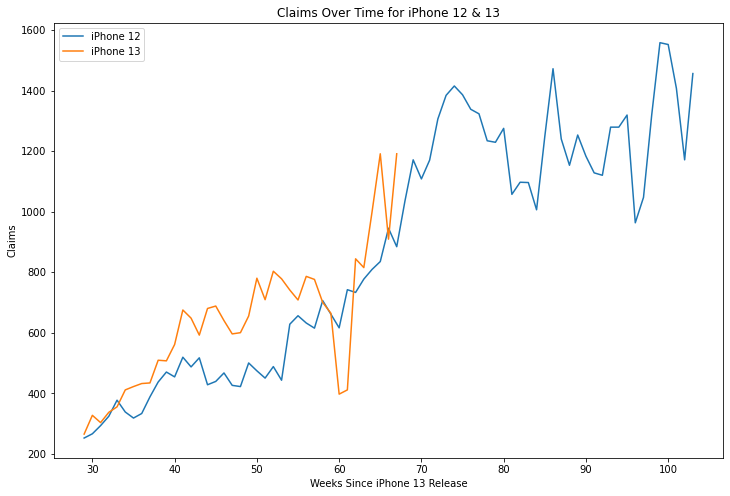

In [37]:
plt.plot(new_iphone12['weeks_since_release'], new_iphone12['this_week'], label='iPhone 12')
plt.plot(iphone13_df['weeks_since_release'], iphone13_df['this_week'], label='iPhone 13')

plt.xlabel('Weeks Since iPhone 13 Release')
plt.ylabel('Claims') 
plt.title('Claims Over Time for iPhone 12 & 13')
plt.legend()
plt.show()

In [51]:
iphone13_df

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
22,204,2022-05-16,5,2022,265,276.20,135.50,265.0,221.0,206.0,215.0,29
23,211,2022-05-23,5,2022,327,276.20,135.50,265.0,265.0,221.0,206.0,30
24,218,2022-05-30,5,2022,303,276.20,135.50,327.0,265.0,265.0,221.0,31
25,225,2022-06-06,6,2022,337,381.25,276.20,303.0,327.0,265.0,265.0,32
26,232,2022-06-13,6,2022,355,381.25,276.20,337.0,303.0,327.0,265.0,33
27,239,2022-06-20,6,2022,411,381.25,276.20,355.0,337.0,303.0,327.0,34
28,246,2022-06-27,6,2022,422,381.25,276.20,411.0,355.0,337.0,303.0,35
29,253,2022-07-04,7,2022,432,470.50,381.25,422.0,411.0,355.0,337.0,36
30,260,2022-07-11,7,2022,434,470.50,381.25,432.0,422.0,411.0,355.0,37
31,267,2022-07-18,7,2022,509,470.50,381.25,434.0,432.0,422.0,411.0,38


In [38]:
X_train, y_train = prepare_data(new_iphone12)

In [39]:
iphone13_validate = iphone13_df[(iphone13_df['weeks_monday'] <= '2022-07-25')].reset_index()
X_validate, y_validate = prepare_data(iphone13_validate)

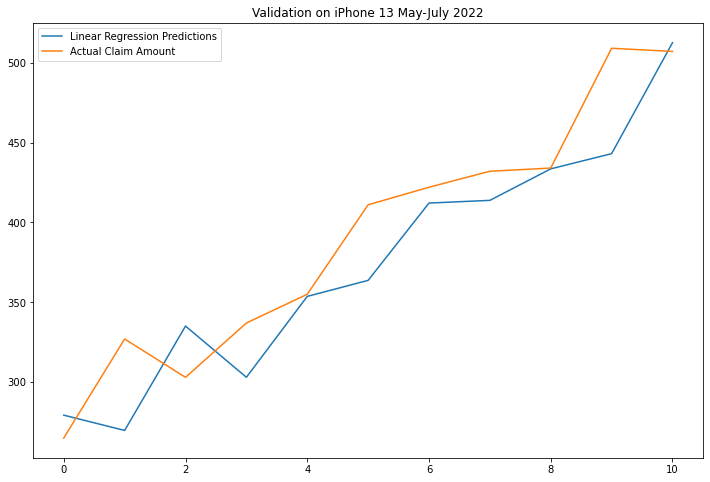

Root Mean sqaured error for Linear Regression model is:  34.00535100247034
WMAPE: 6.66%


In [40]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_validate)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(lin_pred, label = "Linear Regression Predictions")
plt.plot(y_validate, label = "Actual Claim Amount")
plt.title("Validation on iPhone 13 May-July 2022")
plt.legend(loc="upper left")
plt.show()
rmse_lr = sqrt(mean_squared_error(lin_pred, y_validate))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

y_validate_series = pd.Series(y_validate.ravel())
lin_pred_series = pd.Series(lin_pred.ravel())
wmape_score = wmape(y_validate_series, lin_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

In [41]:
def predict_next_claim_amount(df, weeks_this_month, growth_init, loss):
    growth_adjustment = growth_init
    
    for i in range(weeks_this_month): 
        x1 = df.iloc[-1]['this_week']
        x2 = df.iloc[-1]['1_week_ago']
        x3 = df.iloc[-1]['2_week_ago']
        x4 = df.iloc[-1]['3_week_ago']
        days = int(df.iloc[-1]['days_since_release_date']) + 7
        x5 = days // 7 
        x6 = df.iloc[-1]['avg_claim_this_month']

        x1, x2, x3, x4, x5, x6 = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6)
        x1, x2, x3, x4, x5, x6 = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1)
        X_next = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
        next_pred = lin_model.predict(X_next).item()
        
        if i > 0:
            growth_adjustment *= (1 - loss)
            
        next_pred += growth_adjustment

        new_row = {
            'this_week': next_pred,
            '1_week_ago': x1.item(),
            '2_week_ago': x2.item(),
            '3_week_ago': x3.item(),
            '4_week_ago': x4.item(),
            'weeks_since_release': x5.item(),
            'days_since_release_date': days, 
            'avg_claim_last_month': x6.item(),
            'avg_claim_this_month': x6.item()
        }

        df = df.append(new_row, ignore_index=True)

    rolling_avg = df['this_week'].rolling(weeks_this_month).mean().iloc[-1]
    df.iloc[-weeks_this_month:, df.columns.get_loc('avg_claim_this_month')] = rolling_avg
    return df

My Predictions:
[541.43995042 587.82341958 627.22752121 654.74179811 680.39134049]
Actual:
[561 675 648 592 680]


My Prediction Avg claim this month:618.3248059602266
Actual Avg claim this month: 631.2


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


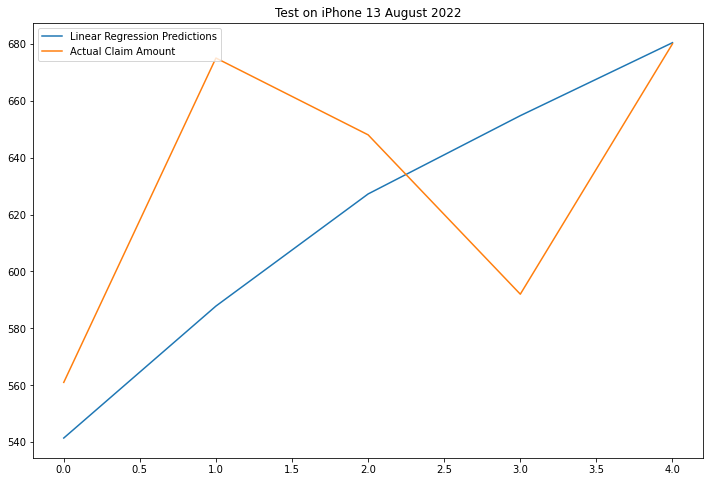

Root Mean sqaured error for Linear Regression model is:  49.70016894610536
WMAPE: 6.04%


In [46]:
weeks_in_Aug22 = 5
iPhone13_predict_Aug22 = iphone13_df.iloc[:11].copy()
iPhone13_predict_Aug22 = predict_next_claim_amount(iPhone13_predict_Aug22, weeks_in_Aug22, 50, 0)
my_pred = iPhone13_predict_Aug22['this_week'].tail(weeks_in_Aug22).to_numpy()
print("My Predictions:")
print(my_pred)

truth = np.array(iphone13_df.iloc[11:16]['this_week'].values)
print("Actual:")
print(truth)

print("\n")

my_pred_avg_claim_this_month = iPhone13_predict_Aug22.iloc[-1]['avg_claim_this_month']
print("My Prediction Avg claim this month:" + str(my_pred_avg_claim_this_month))

actual_avg_claim_this_month = iphone13_df.iloc[11]['avg_claim_this_month']
print("Actual Avg claim this month: " + str(actual_avg_claim_this_month))

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(my_pred, label = "Linear Regression Predictions")
plt.plot(truth, label = "Actual Claim Amount")
plt.title("Test on iPhone 13 August 2022")
plt.legend(loc="upper left")
plt.show()
rmse_lr = sqrt(mean_squared_error(my_pred, truth))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

truth_series = pd.Series(truth.ravel())
my_pred_series = pd.Series(my_pred.ravel())
wmape_score = wmape(truth_series, my_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

My Predictions:
[324.03456259 363.57675997 396.21393556 415.41788785]
Actual:
[337 355 411 422]


My Prediction Avg claim this month:374.81078649318187
Actual Avg claim this month: 381.25


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


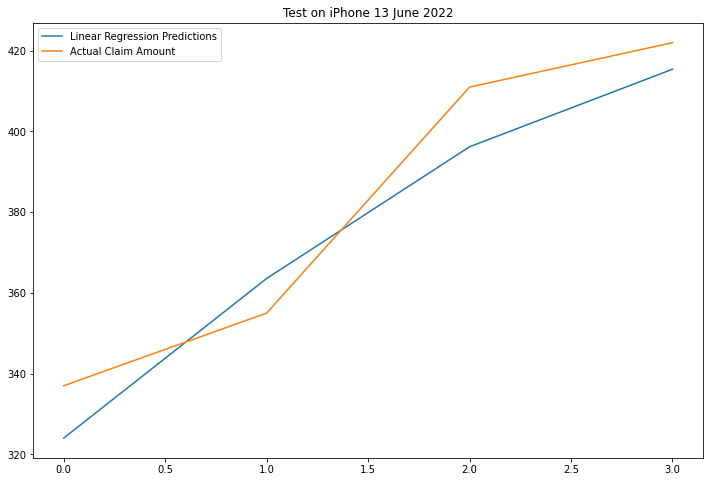

Root Mean sqaured error for Linear Regression model is:  11.22068715010453
WMAPE: 2.81%


In [57]:
weeks_in_June22 = 4
iPhone13_WIP_predictJune22 = iphone13_df.iloc[:3].copy()
iPhone13_WIP_predictJune22  = predict_next_claim_amount(iPhone13_WIP_predictJune22, weeks_in_June22, 21, 0)

my_pred = iPhone13_WIP_predictJune22['this_week'].tail(weeks_in_June22).to_numpy()
print("My Predictions:")
print(my_pred)

truth = np.array(iphone13_df.iloc[3:7]['this_week'].values)
print("Actual:")
print(truth)

print("\n")

my_pred_avg_claim_this_month = iPhone13_WIP_predictJune22.iloc[-1]['avg_claim_this_month']
print("My Prediction Avg claim this month:" + str(my_pred_avg_claim_this_month))

actual_avg_claim_this_month = iphone13_df.iloc[3]['avg_claim_this_month']
print("Actual Avg claim this month: " + str(actual_avg_claim_this_month))

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(my_pred, label = "Linear Regression Predictions")
plt.plot(truth, label = "Actual Claim Amount")
plt.title("Test on iPhone 13 June 2022")
plt.legend(loc="upper left")
plt.show()
rmse_lr = sqrt(mean_squared_error(my_pred, truth))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

truth_series = pd.Series(truth.ravel())
my_pred_series = pd.Series(my_pred.ravel())
wmape_score = wmape(truth_series, my_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

My Predictions:
[444.78055196 466.13300687 481.56862892 491.49699697]
Actual:
[432 434 509 507]


My Prediction Avg claim this month:470.99479618116504
Actual Avg claim this month: 470.5


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


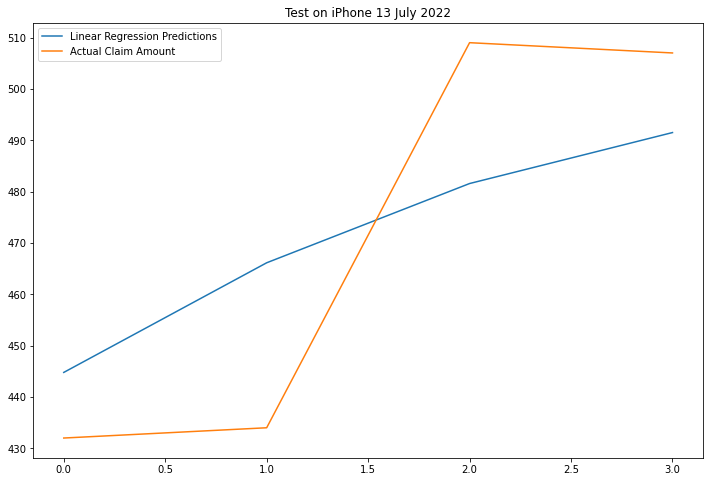

Root Mean sqaured error for Linear Regression model is:  23.39174993817119
WMAPE: 4.67%


In [55]:
weeks_in_July22 = 4
iPhone13_WIP_predictJuly22 = iphone13_df.iloc[:7].copy()
iPhone13_WIP_predictJuly22  = predict_next_claim_amount(iPhone13_WIP_predictJuly22, weeks_in_July22, 31, 0.3)

my_pred = iPhone13_WIP_predictJuly22['this_week'].tail(weeks_in_June22).to_numpy()
print("My Predictions:")
print(my_pred)

truth = np.array(iphone13_df.iloc[7:11]['this_week'].values)
print("Actual:")
print(truth)
print("\n")

my_pred_avg_claim_this_month = iPhone13_WIP_predictJuly22.iloc[-1]['avg_claim_this_month']
print("My Prediction Avg claim this month:" + str(my_pred_avg_claim_this_month))

actual_avg_claim_this_month = iphone13_df.iloc[7]['avg_claim_this_month']
print("Actual Avg claim this month: " + str(actual_avg_claim_this_month))

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(my_pred, label = "Linear Regression Predictions")
plt.plot(truth, label = "Actual Claim Amount")
plt.title("Test on iPhone 13 July 2022")
plt.legend(loc="upper left")
plt.show()
rmse_lr = sqrt(mean_squared_error(my_pred, truth))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

truth_series = pd.Series(truth.ravel())
my_pred_series = pd.Series(my_pred.ravel())
wmape_score = wmape(truth_series, my_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


My Predictions:
[634.56828691 652.97462126 656.46739678 662.97441741]
Actual:
[688 640 596 600]


My Prediction Avg claim this month:651.7461805905446
Actual Avg claim this month: 631.0


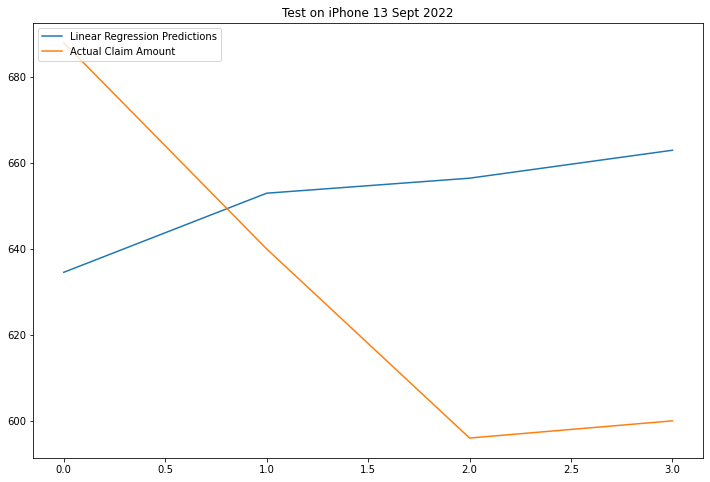

Root Mean sqaured error for Linear Regression model is:  51.5882062159414
WMAPE: 7.52%


In [20]:
weeks_in_Sept22 = 4
iPhone13_WIP_predictSept22 = iphone13_df.iloc[:20].copy()
iPhone13_WIP_predictSept22  = predict_next_claim_amount(iPhone13_WIP_predictSept22, weeks_in_Sept22, 0)

my_pred = iPhone13_WIP_predictSept22['this_week'].tail(weeks_in_June22).to_numpy()
print("My Predictions:")
print(my_pred)

truth = np.array(iphone13_df.iloc[16:20]['this_week'].values)
print("Actual:")
print(truth)

print("\n")

my_pred_avg_claim_this_month = iPhone13_WIP_predictSept22.iloc[-1]['avg_claim_this_month']
print("My Prediction Avg claim this month:" + str(my_pred_avg_claim_this_month))

actual_avg_claim_this_month = iphone13_df.iloc[16]['avg_claim_this_month']
print("Actual Avg claim this month: " + str(actual_avg_claim_this_month))

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(my_pred, label = "Linear Regression Predictions")
plt.plot(truth, label = "Actual Claim Amount")
plt.title("Test on iPhone 13 Sept 2022")
plt.legend(loc="upper left")
plt.show()
rmse_lr = sqrt(mean_squared_error(my_pred, truth))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

truth_series = pd.Series(truth.ravel())
my_pred_series = pd.Series(my_pred.ravel())
wmape_score = wmape(truth_series, my_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

In [21]:
iphone13_df

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
22,204,2022-05-16,5,2022,265,276.20,135.50,265.0,221.0,206.0,215.0,29
23,211,2022-05-23,5,2022,327,276.20,135.50,265.0,265.0,221.0,206.0,30
24,218,2022-05-30,5,2022,303,276.20,135.50,327.0,265.0,265.0,221.0,31
25,225,2022-06-06,6,2022,337,381.25,276.20,303.0,327.0,265.0,265.0,32
26,232,2022-06-13,6,2022,355,381.25,276.20,337.0,303.0,327.0,265.0,33
27,239,2022-06-20,6,2022,411,381.25,276.20,355.0,337.0,303.0,327.0,34
28,246,2022-06-27,6,2022,422,381.25,276.20,411.0,355.0,337.0,303.0,35
29,253,2022-07-04,7,2022,432,470.50,381.25,422.0,411.0,355.0,337.0,36
30,260,2022-07-11,7,2022,434,470.50,381.25,432.0,422.0,411.0,355.0,37
31,267,2022-07-18,7,2022,509,470.50,381.25,434.0,432.0,422.0,411.0,38


In [22]:
iphone14_df

,days_since_release_date,weeks_monday,month,year,month_year,holiday,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,87,2022-12-12,12,2022,2022-12-01,0,32,38.75,20.666667,43.0,23.0,30.0,9.0,12
1,94,2022-12-19,12,2022,2022-12-01,1,36,38.75,20.666667,32.0,43.0,23.0,30.0,13
2,101,2022-12-26,12,2022,2022-12-01,1,44,38.75,20.666667,36.0,32.0,43.0,23.0,14
3,108,2023-01-02,1,2023,2023-01-01,0,45,55.00,38.750000,44.0,36.0,32.0,43.0,15
4,115,2023-01-09,1,2023,2023-01-01,0,59,55.00,38.750000,45.0,44.0,36.0,32.0,16
5,122,2023-01-16,1,2023,2023-01-01,0,60,55.00,38.750000,59.0,45.0,44.0,36.0,17
6,129,2023-01-23,1,2023,2023-01-01,0,57,55.00,38.750000,60.0,59.0,45.0,44.0,18
7,136,2023-01-30,1,2023,2023-01-01,0,54,55.00,38.750000,57.0,60.0,59.0,45.0,19
8,143,2023-02-06,2,2023,2023-02-01,0,61,35.50,55.000000,54.0,57.0,60.0,59.0,20
